## Triplet Loss

- we will train a handwritten character identification network with triplet loss
- 코드 외부 공유 금지 (오리지널 저작물을 포함하고 있습니다)

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import os
import torchvision
import torchvision.transforms as transforms
import random
import torch.nn.functional as F
from tqdm import tqdm

/home/alice/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

In [ ]:
# First, get the dataset from the internet
# just run this code
transform = transforms.Compose([
    transforms.Resize((105, 105)), # Omniglot images are typically 105x105
    transforms.ToTensor(),
    # Add more transforms as needed, e.g., transforms.Normalize
])
omniglot_dataset = torchvision.datasets.Omniglot(
    root='./data',  # Specify the root directory to store the dataset
    background=True, # Set to True for the "background" set, False for "evaluation" set
    transform=transform,
    download=True    # Set to True to download the dataset if not already present
)


In [ ]:
class OmniglotDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.data_dir = data_dir
        # TODO: append every image path into this array
        self.paths = [] 
        # example "Korean/character01/0643_01.png"
        # DO NOT include data_dir part ("./data/omniglot-py/Korean/character01/0643_01.png" X) 
        
        # give each directory a unique numerical label
        dirs = [os.path.join(*os.path.split(p)[:-1]) for p in self.paths]
        unique_dirs = sorted(list(set(dirs)))
        self.dir2idx = {d:idx for (idx, d) in enumerate(unique_dirs)}
        self.labels = [self.dir2idx[d] for d in dirs]
        self.dirs = unique_dirs
        
        # transforms
        self.transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)
        
    def __getitem__(self, index):
        # get the index-th image and label
        a_image     = Image.open(os.path.join(self.data_dir, self.paths[index]))
        a_image     = self.transforms(a_image)
        
        # I have split directory part and filename for you
        a_filename  = os.path.basename(self.paths[index])   # of form '0932_02.png'
        a_dir       = os.path.dirname(self.paths[index])    # of form 'Tifinagh/character23'
        
        # you can get the label from the front part of filename
        label       = int(a_filename.split("_")[0])
        
        # TODO: get a positive image, from the same directory(a_dir) as anchor, but a different image!
        # one way to do this is use random.choice() from a list of paths except anchor's path.
        # you can use the fact there are 20 images inside each folder, and the images are named _01, ... _20
        ...
        
        p_image     = Image.open(...)
        p_image     = self.transforms(p_image)
        
        
        # TODO: get a negative image, from a random directory other than a_dir
        # self.dirs contains a list of all dirs of form ['Gujarati/character01'...]
        # you may sample from this list.
        
        n_image     = Image.open(...)
        n_image     = self.transforms(n_image)
        n_label     = ... # refer to 'label' for how to extract numerical label from path
        
        return a_image, p_image, n_image, label, n_label
    

### Visualize the Dataset

tensor([837, 756, 428, 948, 148, 441, 265, 677, 521, 728, 870, 710, 400, 834,
        185, 544, 751, 236, 260, 594,  61,  46, 848, 446, 250, 523, 882, 345,
         61, 522, 254, 215, 442, 696, 734, 672, 941, 471, 717, 858, 197,  18,
        194, 378, 384, 232, 860, 353, 540, 544, 325, 809, 939, 769, 352, 880,
         89, 341, 351, 901, 888, 850, 834, 647])


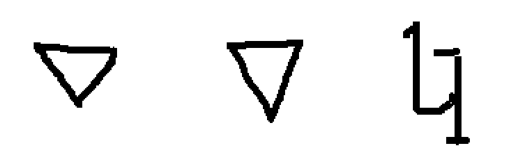

In [155]:
train_dataset = OmniglotDataset('data/omniglot-py/images_background')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

fig, ax = plt.subplots(1, 3)
for (a_image, p_image, n_image, label, n_label) in train_loader:
    print(label)
    ax[0].imshow(a_image[0].numpy().transpose(1, 2, 0), cmap='grey')
    ax[1].imshow(p_image[0].numpy().transpose(1, 2, 0), cmap='grey')
    ax[2].imshow(n_image[0].numpy().transpose(1, 2, 0), cmap='grey')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    break
    

### defining the model

In [167]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 2, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((4, 4), stride=4),
            nn.Conv2d(32, 32, 2, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((4, 4), stride=4),
            nn.Conv2d(32, 32, 2, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((4, 4), stride=4)
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x.flatten(1)
    

In [239]:
model = Network().cuda()

### implement random batch-negative sampling

In [180]:
# we will be using the euclidean distance as the similarity metric

def similarity_metric(x, y):
    return (x - y).square().mean(dim=-1)

In [173]:
MARGIN = 0.2

In [ ]:
# DO NOT CHANGE THIS CELL
# this cell performs the verification task
# see what score you get!
data_dir = "data/omniglot-py/images_background"

unknown_paths = []
unknown_labels = []
known_paths = []
known_labels = []

for top_dir in os.listdir(data_dir):
    for char_dir in os.listdir(os.path.join(data_dir, top_dir)):
        file_dir = os.path.join(data_dir, top_dir, char_dir)
        for i, filename in enumerate(os.listdir(file_dir)):
            label = int(filename.split("_")[0])
            if i == 0:
                unknown_paths.append(os.path.join(file_dir, filename))
                unknown_labels.append(label)
            elif i == 1:
                known_paths.append(os.path.join(file_dir, filename))
                known_labels.append(label)
            else:
                break

unknown_images = [Image.open(p) for p in unknown_paths]
known_images = [Image.open(p) for p in known_paths]

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

unknown_images = torch.stack([transform(x) for x in unknown_images])
known_images  = torch.stack([transform(y) for y in known_images])
unknown_labels = torch.LongTensor(unknown_labels).cuda()
known_labels = torch.LongTensor(known_labels).cuda()


def evaluate_model(model):
    unknown_feats, known_feats = [], []
    batch_size = 64
    model.eval()

    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] 
        with torch.no_grad():
            unknown_feat = model.forward(unknown_batch.float().cuda())
        unknown_feats.append(unknown_feat)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
            known_feat = model.forward(known_batch.float().cuda())
        known_feats.append(known_feat)

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity_metric(unknown_feats, known_feature) for known_feature in known_feats])
    max_similarity_values, predictions = similarity_values.min(0) #Why are we doing an max here, where are the return values?
    predicted_labels = known_labels[predictions]

    num_correct = (predicted_labels == unknown_labels).sum()
    accuracy = num_correct.item()/len(unknown_labels)
    model.train()
    
    print(f"eval accuracy = {accuracy*100:.4f}%")
    return accuracy

In [ ]:

optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)

for epoch in range(10):
    total_loss = 0.0
    model.train()
    for (a_image, p_image, n_image, label, n_label) in tqdm(train_loader):
        optimizer.zero_grad()
        a_image, p_image, n_image = a_image.cuda(), p_image.cuda(), n_image.cuda()
        anchors     = model(a_image) # shape = [B=64, D=32]
        positives   = model(p_image)
        negatives   = model(n_image)
        
        # compute distances between (anchor, positive) and (anchor, negative)
        # (a-b).square().mean(dim=-1)
        ap_distance = ...
        an_distance = ...
        
        # what should the triplet loss be?
        # hint: use F.relu
        loss        = ...
    
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"epoch [{epoch}] loss={total_loss/len(train_loader):.4f}")
    evaluate_model(model)

100%|██████████| 302/302 [00:14<00:00, 21.24it/s]


epoch [0] loss=0.1998
eval accuracy = 2.0747%


100%|██████████| 302/302 [00:14<00:00, 21.54it/s]


epoch [1] loss=0.1574
eval accuracy = 1.9710%


100%|██████████| 302/302 [00:14<00:00, 21.49it/s]


epoch [2] loss=0.0958
eval accuracy = 4.5643%


100%|██████████| 302/302 [00:14<00:00, 21.24it/s]


epoch [3] loss=0.0700
eval accuracy = 7.6763%


100%|██████████| 302/302 [00:14<00:00, 21.09it/s]


epoch [4] loss=0.0522
eval accuracy = 10.2697%


100%|██████████| 302/302 [00:13<00:00, 22.73it/s]


epoch [5] loss=0.0419
eval accuracy = 10.6846%


100%|██████████| 302/302 [00:13<00:00, 22.31it/s]


epoch [6] loss=0.0359
eval accuracy = 13.0705%


100%|██████████| 302/302 [00:14<00:00, 21.06it/s]


epoch [7] loss=0.0335
eval accuracy = 14.2116%


100%|██████████| 302/302 [00:14<00:00, 21.48it/s]


epoch [8] loss=0.0284
eval accuracy = 15.0415%


100%|██████████| 302/302 [00:14<00:00, 20.38it/s]

epoch [9] loss=0.0275
eval accuracy = 16.1826%


### Visualizing the Result

torch.Size([32, 1])
d_pos=0.28959375619888306
d_neg=1.003736138343811


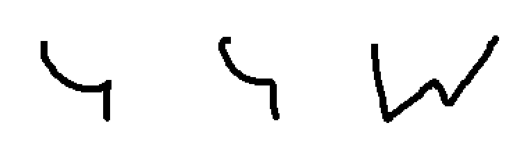

In [ ]:
a_image, p_image, n_image, labels, n_labels = train_dataset[0]
fig, ax = plt.subplots(1, 3)
ax[0].imshow(a_image.numpy().transpose(1, 2, 0), cmap='grey')
ax[1].imshow(p_image.numpy().transpose(1, 2, 0), cmap='grey')
ax[2].imshow(n_image.numpy().transpose(1, 2, 0), cmap='grey')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

a_image, p_image, n_image = a_image.cuda(), p_image.cuda(), n_image.cuda()
model.eval()
with torch.no_grad():
    anchors     = model(a_image)
    positives   = model(p_image)
    negatives   = model(n_image)

# compute distances between (anchor, positive) and (anchor, negative)
ap_distance = (anchors - positives).square().mean()
an_distance = (anchors - negatives).square().mean()

print(f"d_pos={ap_distance.item()}")
print(f"d_neg={an_distance.item()}")

### Hard Negative Mining

In the last part of the session, you will implement an online (batch) version of hard negative mining. For each anchor image in a batch, find the hardest negative(closest one to the anchor) amongst other anchor images in the batch, and concatenate the hardest negatives into a training batch.

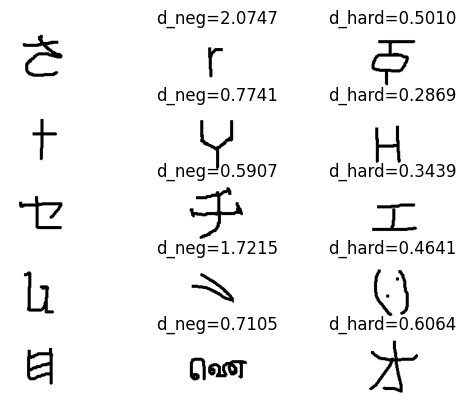

In [ ]:
for anchor_imgs, pos_imgs, neg_imgs, labels, n_labels in train_loader:
    anchor_imgs, neg_imgs   = anchor_imgs.cuda(), neg_imgs.cuda()
    # you first have to extract the features!
    anchors                 = model(anchor_imgs)
    hardest_negatives       = []
    hardest_negative_labels = []
    for i in range(len(labels)):
        anchor_label = labels[i]
        # TODO: from anchor_images, find the sample that is closest to the i-th sample
        # that's the one with smallest similarity_metric value to anchors[i]
        # append the image to hardest_negatives array, append label to the hardest_negative_labels array.
        
        # use nonzero() with boolean comparison (x!=y) to filter out
        # positive samples in the batch
        # you can use argmin() to find the index with smallest similarity_metric value.
        hardest_negative_idx = (labels != anchor_label).nonzero(as_tuple=True)[0]
        dists = similarity_metric(anchors[i], anchors[hardest_negative_idx])
        hardest_negative_idx = hardest_negative_idx[dists.argmin()]
        hardest_negatives.append(anchor_imgs[hardest_negative_idx])
        hardest_negative_labels.append(labels[hardest_negative_idx])
        
        
    hard_neg_imgs    = torch.stack(hardest_negatives)
    hard_neg_labels  = torch.stack(hardest_negative_labels)
    assert (labels == hard_neg_labels).sum() == 0
    negatives        = model(neg_imgs)
    hard_negatives   = model(hard_neg_imgs)
    
    fig, ax = plt.subplots(5, 3)
    for i in range(5):
        ax[i, 0].imshow(anchor_imgs[i].cpu().numpy().transpose(1, 2, 0), cmap='grey')
        ax[i, 1].imshow(neg_imgs[i].cpu().numpy().transpose(1, 2, 0), cmap='grey')
        ax[i, 2].imshow(hard_neg_imgs[i].cpu().numpy().transpose(1, 2, 0), cmap='grey')
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
        ax[i, 2].axis('off')
        ax[i, 1].title.set_text(f"d_neg={similarity_metric(anchors[i], negatives[i]).item():.4f}")
        ax[i, 2].title.set_text(f"d_hard={similarity_metric(anchors[i], hard_negatives[i]).item():.4f}")
    break

In [ ]:
# train with hard negative sampling..
for epoch in range(5):
    model.train()
    for anchor_imgs, pos_imgs, neg_imgs, labels, n_labels in tqdm(train_loader):
        optimizer.zero_grad()
        anchor_imgs, pos_imgs, neg_imgs  = anchor_imgs.cuda(), pos_imgs.cuda(), neg_imgs.cuda()
        # you first have to extract the features!
        anchors = model(anchor_imgs)
        hardest_negatives = []
        hardest_negative_labels = []
        for i in range(len(labels)):
            anchor_label = labels[i]
            # TODO: copy and paste your batch-hard-negative-mining code here
            # REPLACE 5 LINES BELOW WITH YOUR CODE
            hardest_negative_idx = (labels != anchor_label).nonzero(as_tuple=True)[0]
            dists = similarity_metric(anchors[i], anchors[hardest_negative_idx])
            hardest_negative_idx = hardest_negative_idx[dists.argmin()]
            hardest_negatives.append(anchor_imgs[hardest_negative_idx])
            hardest_negative_labels.append(labels[hardest_negative_idx])
            ## REPLACE END            
            
        hard_neg_imgs    = torch.stack(hardest_negatives)
        
        positives   = model(pos_imgs)
        negatives   = model(hard_neg_imgs)
        
        ap_distance = (anchors - positives).square().mean(dim = -1)
        an_distance = (anchors - negatives).square().mean(dim = -1)
        
        # what should the triplet loss be?
        loss = F.relu((ap_distance - an_distance + MARGIN)).mean()
    
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"epoch [{epoch}] loss={total_loss/len(train_loader):.4f}")
    evaluate_model(model)


epoch [0] loss=0.2315
eval accuracy = 19.2946%
epoch [1] loss=0.4257
eval accuracy = 21.0581%
epoch [2] loss=0.6149
eval accuracy = 24.4813%
epoch [3] loss=0.7952
eval accuracy = 25.9336%
epoch [4] loss=0.9697
eval accuracy = 25.6224%
